## Stati quantistici di un qubit:

- Uno stato quantistico generico di un qbit può essere scritto come la sovrapposizione 
  di due stati:
    $$
    \left|\psi\right\rangle = \alpha\left|0\right\rangle + \beta \left|1\right\rangle =
    \begin{pmatrix}
    \alpha \\
    \beta
    \end{pmatrix}.
    $$

    dove $\alpha$ and $\beta$ sono numeri complessi. 

- Dopo una misura, la probabilità che il sistema sia in $\left|0\right\rangle$ è $|\alpha|^2$ 
- Dopo una misura, la probabilità che il sistema sia in $\left|1\right\rangle$ è $|\beta|^2$. 

dato che $|\alpha|^2+ |\beta|^2 = 1$ e dato che la fase globale non è rilevabile  $\left|\psi\right\rangle := e^{i\delta} \left|\psi\right\rangle$ abbiamo bisogno solo di due numeri reali per descrivere lo stato di un singolo qbit.


$$\left|\psi\right\rangle = \cos(\theta/2)\left|0\right\rangle + \sin(\theta/2)e^{i\phi}\left|1\right\rangle$$

dove $0\leq \phi < 2\pi$, e $0\leq \theta \leq \pi$.  

Ne consegue che, come evidenziato vi è la possibilità di mappare tutti gli stati dei qbit ($\mathbb{C}^2$) sui punti della sfera unitaria
($\mathbb{R}^3$).



In [6]:
## Quantum Teleportation experiment
## Andres Coronado - Luca Frontirre` 
## Unige - Assignment by prof. Solinas
import math
import qiskit as qk

from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit

#useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

from qiskit.tools.visualization import circuit_drawer
 
#visualization
from qiskit.visualization import(
  plot_state_city,
  plot_bloch_multivector,
  plot_state_paulivec,
  plot_state_hinton,
  plot_state_qsphere,
)


IBMQ.save_account(open("token.txt").read())
IBMQ.load_account()

# funzione che inizializza uno stato quantistico 
# |psi> = sqrt(alpha)|0> + sqrt(1-alpha)|1>
def initializeQuantumState(p,qC):
    desired_vector = [
    
    math.sqrt(p) * complex(0, 1),
    math.sqrt(1-p) * complex(1, 0)
    
    ]
    
    qC.initialize(desired_vector,[0])
   

    
    #pretty print 
    print("Desired probabilities: ")
    
    print(str(
        list(
            map(
                lambda x: format(abs(x * x), '.3f'), desired_vector
            )
        )
    ))
    
    return

# Crea stato entangled 
def createBellEntangledState(qCircuit,aliceQBit,BobQbit):
    qCircuit.h(aliceQBit)
    qCircuit.cx(aliceQBit,BobQbit)
    return   

Credentials already present. Set overwrite=True to overwrite.
Credentials are already in use. The existing account in the session will be replaced.


In [25]:
# circuit: circuito quantistico dove implementare il teletraasporto
# aliceFstQbit: stato psi da teletrasportare attraverso il protocollo
# aliceSndQbit: un Qbit appartenente ad Alice
# bobQbit: un Qbit appartenente a Bob

def deployTeleportProtocol(qCircuit, aliceFstQbit, aliceSndQbit, bobQbit, measureBits):
    createBellEntangledState(qCircuit,aliceSndQbit,bobQbit)
    qCircuit.cx(aliceFstQbit,aliceSndQbit)
    qCircuit.h(aliceFstQbit)   
    qCircuit.cx(aliceSndQbit,bobQbit)
    qCircuit.cz(aliceFstQbit,bobQbit)
    qCircuit.measure(aliceFstQbit, measureBits[0])
    qCircuit.measure(aliceSndQbit, measureBits[1])
    qCircuit.measure(bobQbit, measureBits[2])

In [26]:

def buildCircuit(modAlphaSquared):
    # contiene i qbit: due di Alice uno di Bob 
    q = QuantumRegister(3) 
    # per effettuare le misure
    c = ClassicalRegister(3)
    # contiene il programma che verra` eseguito
    qc = QuantumCircuit(q,c)
    initializeQuantumState(modAlphaSquared,qc)
    deployTeleportProtocol(qc,q[0],q[1],q[2],c)
    return qc




Desired probabilities: 
['0.900', '0.100']


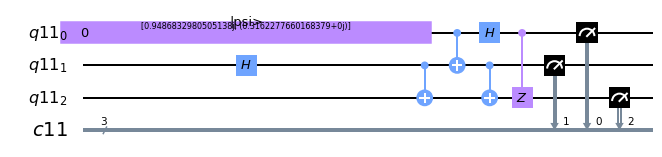

In [27]:
qc = buildCircuit(0.9)
qc.draw(output='mpl',scale=0.5)

Desired probabilities: 
['0.300', '0.700']


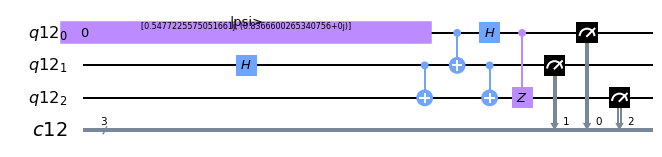

In [28]:
qc2 = buildCircuit(0.3)
qc2.draw(output='mpl',scale=0.5)

In [29]:
#printing out all the queues
provider = IBMQ.get_provider("ibm-q")

for backend in provider.backends():
    try:
        qubit_count =  len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
        
    #Italian Front-End :-D
    print(f"[{backend.name()}] ha {backend.status().pending_jobs} lavori in coda e {qubit_count} qubits")

[ibmq_qasm_simulator] ha 0 lavori in coda e simulated qubits
[ibmqx2] ha 72 lavori in coda e 5 qubits
[ibmq_16_melbourne] ha 89 lavori in coda e 15 qubits
[ibmq_vigo] ha 1 lavori in coda e 5 qubits
[ibmq_ourense] ha 0 lavori in coda e 5 qubits
[ibmq_london] ha 24 lavori in coda e 5 qubits
[ibmq_burlington] ha 0 lavori in coda e 5 qubits
[ibmq_essex] ha 0 lavori in coda e 5 qubits
[ibmq_armonk] ha 2 lavori in coda e 1 qubits


In [32]:
#chose one backend (less queue the better... need to wait....)
from qiskit.tools.monitor import job_monitor
backend = provider.get_backend("ibmq_ourense")


job = qk.execute(qc, backend=backend, shots=1024)
job2 = qk.execute(qc2, backend=backend, shots=1024)

job_monitor(job)
job_monitor(job2)

Job Status: job has successfully run
Job Status: job has successfully run


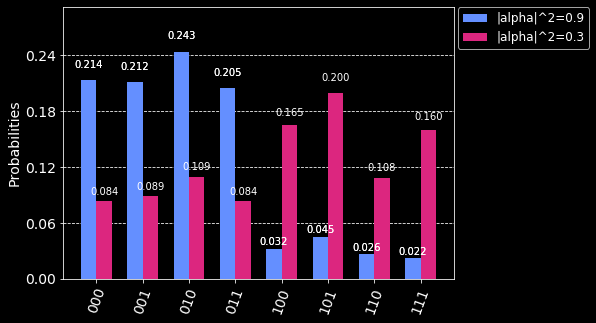

In [33]:
from qiskit.visualization import plot_histogram
from matplotlib import style

#dark background on jupyterLab...
style.use("dark_background")

# Plot results with legend
legend = ['|alpha|^2=0.9', '|alpha|^2=0.3']

result=job.result()
result2=job2.result()

counts = result.get_counts(qc)
counts2 = result2.get_counts(qc2)

plot_histogram([counts, counts2], legend=legend)
